Importar libs

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
import trimesh

Extração dos dados

In [326]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    
    # Calcular altura da imagem original em 60% da parte superior
    img_height = int(img.shape[0] * 0.60)
    img = img[:img_height, :]
    
    # Converter para escala de cinza
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize para 224x224
    img = cv2.resize(img, (224, 224))
    
    # 3 canais para manter compatibilidade com MobileNetV2
    img = np.stack((img,)*3, axis=-1)
    
    # Normalizar para [0,1]
    img = img / 255.0
    
    return img

Preparar dados de treinamento

In [327]:
# Buscar imagens no diretório

imgs_root = "post-processed"

folders = sorted(os.listdir(imgs_root))

original_img_dataset = pd.DataFrame(columns=['img', 'id'])
img_dataset = pd.DataFrame(columns=['img', 'id'])

for idx, folder in enumerate(folders):
    folder_path = os.path.join(imgs_root, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder_path, filename)
                img_original = cv2.imread(img_path)
                img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
                try:
                    # Separar os ids por pessoa

                    # Dataset de imagens originais, com as imagens em RGB que não foram processadas e não são utilizadas para o treinamento
                    original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [idx]})], ignore_index=True)
                    
                    # Dataset de imagens processadas, com as imagens em escala de cinza que são utilizadas para o treinamento
                    img = preprocess_image(img_path)
                    img_dataset = pd.concat([img_dataset, pd.DataFrame({'img': [img], 'id': [idx]})], ignore_index=True)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# print(f"Dataset created with {len(img_dataset)} images.")
print('len data', len(img_dataset))

len data 177


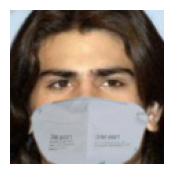

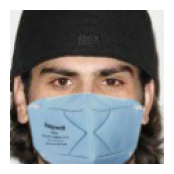

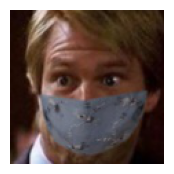

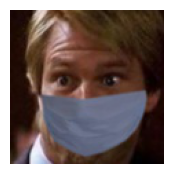

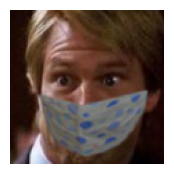

In [328]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(original_img_dataset['img'][i])
    plt.axis('off')
    plt.show()

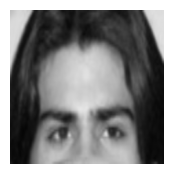

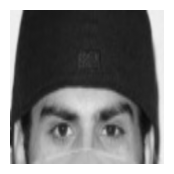

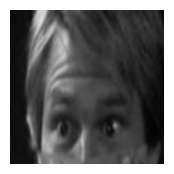

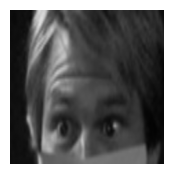

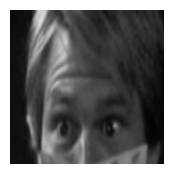

In [329]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(img_dataset['img'][i])
    plt.axis('off')
    plt.show()

In [330]:
X = np.stack(img_dataset['img'].values)
y = img_dataset['id'].values

Configurar modelo

In [331]:
# Criar o modelo base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adicionar camadas para extração de características
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

# Camada final que produzirá o vetor descritor de 128 dimensões
embeddings = Dense(128)(x)

# Normalizar o vetor para ter norma unitária (importante para metric learning)
normalized_embeddings = tf.nn.l2_normalize(embeddings, axis=1)

# Construir o modelo completo
model = Model(inputs=base_model.input, outputs=normalized_embeddings)

# Congelar as camadas do modelo base para fine-tuning
for layer in base_model.layers:
    layer.trainable = False

### Âncora
- É a imagem de referência (ex: uma foto da pessoa A)
- Serve como ponto de comparação para as outras duas imagens

### Positivo
- É outra imagem da **mesma pessoa** da âncora (outra foto da pessoa A)
- Pode ter diferenças como ângulo, iluminação, expressão facial, uso de máscara

### Negativo
- É uma imagem de uma **pessoa diferente** (foto da pessoa B)
- Representa o que o modelo deve aprender a distinguir da âncora

In [332]:
# A classe TripletGenerator é um gerador de dados para o treinamento do modelo
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, num_triplets=5000):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_triplets = num_triplets
        self.classes = np.unique(labels)
        self.indexes = np.arange(num_triplets)
        
    def __len__(self):
        return int(np.ceil(self.num_triplets / self.batch_size))
    
    def __getitem__(self, idx):
        # Batches para o treinamento
        # Cada batch contém um número fixo de tripletos
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_triplets = []
        
        for _ in range(len(batch_indexes)):
            # Escolher classe âncora aleatoriamente
            anchor_class = np.random.choice(self.classes)
            
            # Índices de imagens da mesma classe (positivos)
            positive_indices = np.where(self.labels == anchor_class)[0]
            
            # Índices de imagens de classes diferentes (negativos)
            negative_classes = self.classes[self.classes != anchor_class]
            negative_class = np.random.choice(negative_classes)
            negative_indices = np.where(self.labels == negative_class)[0]
            
            # Escolher âncora e positivo aleatoriamente da mesma classe
            anchor_idx = np.random.choice(positive_indices)
            positive_idx = np.random.choice(positive_indices[positive_indices != anchor_idx])
            
            # Escolher negativo aleatoriamente de outra classe
            negative_idx = np.random.choice(negative_indices)
            
            batch_triplets.append([
                self.images[anchor_idx], 
                self.images[positive_idx], 
                self.images[negative_idx]
            ])
            
        batch_triplets = np.array(batch_triplets)
        triplets_flat = batch_triplets.reshape(-1, 224, 224, 3)
        
        targets = np.zeros(len(batch_indexes) * 3)
        
        return triplets_flat, targets

# A loss function triplet_loss calcula a perda triplet, que é uma função que mede a distância entre âncoras, positivos e negativos
# A ideia é minimizar a distância entre âncoras e positivos, enquanto maximiza a distância entre âncoras e negativos
def triplet_loss(y_true, y_pred, alpha=0.2):
	total = tf.shape(y_pred)[0]
	third = total // 3
	
	anchor = y_pred[0:third]
	positive = y_pred[third:2*third]
	negative = y_pred[2*third:total]
	
	# Calcular distâncias entre âncora, positivo e negativo
	pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
	neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
	
	# Triplet Loss
	basic_loss = pos_dist - neg_dist + alpha
	loss = tf.maximum(basic_loss, 0.0)
	return tf.reduce_mean(loss)

Compilar e treinar o modelo

In [333]:
# Compilar o modelo com a função de perda triplet loss
model.compile(optimizer='adam', loss=triplet_loss)

# Cria o gerador de triplets
triplet_gen = TripletGenerator(X, y, batch_size=32, num_triplets=5000)

# Treina o modelo com o gerador
history = model.fit(
    triplet_gen,
    epochs=10,
    steps_per_epoch=len(triplet_gen),
    verbose=1
)

Epoch 1/10
157/157 [==============================] - 64s 387ms/step - loss: 0.2002
Epoch 2/10
157/157 [==============================] - 65s 413ms/step - loss: 0.2002
Epoch 3/10
157/157 [==============================] - 69s 438ms/step - loss: 0.2001
Epoch 4/10
157/157 [==============================] - 66s 421ms/step - loss: 0.1998
Epoch 5/10
157/157 [==============================] - 65s 415ms/step - loss: 0.2002
Epoch 6/10
157/157 [==============================] - 64s 406ms/step - loss: 0.1999
Epoch 7/10
157/157 [==============================] - 66s 419ms/step - loss: 0.2001
Epoch 8/10
157/157 [==============================] - 65s 415ms/step - loss: 0.2001
Epoch 9/10
157/157 [==============================] - 75s 479ms/step - loss: 0.1998
Epoch 10/10
157/157 [==============================] - 71s 453ms/step - loss: 0.2000


Criar banco de dados com vetores descritores

In [334]:
# Função para extrair vetores descritores
def extract_features(model, images):
    features = model.predict(images)
    return features

In [335]:
# Extrair características de todas as imagens do dataset
celebrity_features = extract_features(model, X)

# Criar banco de dados de características
feature_database = {
    'features': celebrity_features,
    'labels': y
}

# # Podemos também salvar para uso futuro
# np.save('feature_database.npy', feature_database)

6/6 [==============================] - 1s 130ms/step


Adicionar nova pessoa ao banco

In [ ]:
# Carregar a imagem da nova pessoa
new_person_path = "face-test\marcelinho_no_db.jpg"  # Supondo que você já baixou a imagem
new_person_img = preprocess_image(new_person_path)
new_person_img_array = np.expand_dims(new_person_img, axis=0)

# Extrair características
new_person_features = extract_features(model, new_person_img_array)

# Atribuir um novo ID para esta pessoa (após o último ID existente)
new_person_id = np.max(y) + 1

# Adicionar ao banco de dados
img_original = cv2.imread(new_person_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)
feature_database['features'] = np.vstack([feature_database['features'], new_person_features])
feature_database['labels'] = np.append(feature_database['labels'], new_person_id)

print(f"Nova pessoa adicionada ao banco de dados com ID {new_person_id}")

1/1 [==============================] - 0s 43ms/step
Nova pessoa adicionada ao banco de dados com ID 46


Teste final

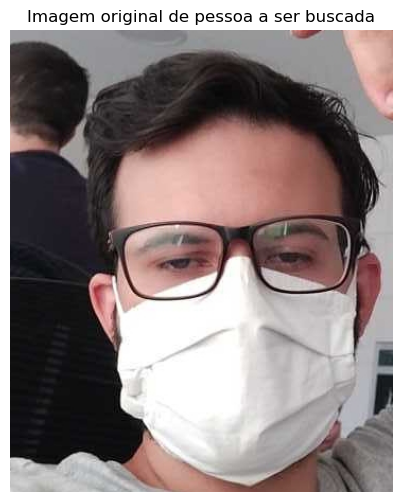

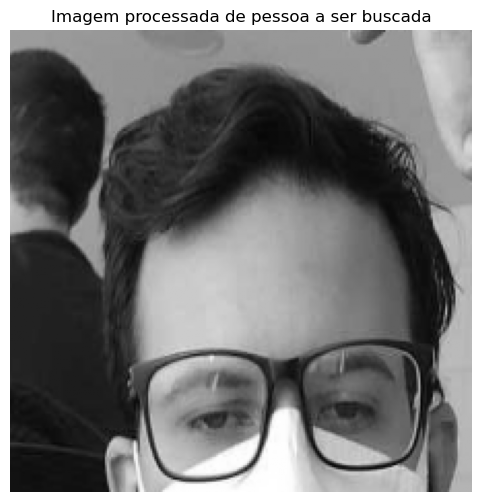

In [342]:
test_image_path = "face-test\marcelinho_na_inferencia.jpg"

# Adicionar ao banco de dados com imagens originais
img_original = cv2.imread(test_image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)

plt.figure(figsize=(6, 6))
plt.imshow(img_original)
plt.title("Imagem original de pessoa a ser buscada")
plt.axis('off')
plt.show()

# Imagem não é adicionada ao banco de dados, apenas pré-processada e utilizada na inferência
test_image = preprocess_image(test_image_path)
test_image_array = np.expand_dims(test_image, axis=0)

# Exibir a imagem a ser buscada
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title("Imagem processada de pessoa a ser buscada")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 28ms/step
Score de similaridade: 0.9995


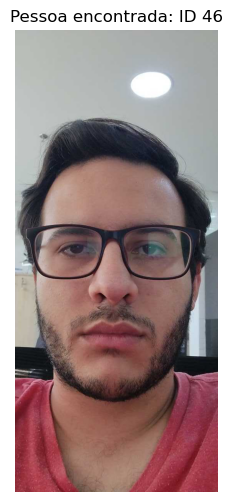

In [343]:
# Extrair características da imagem a ser buscada
test_features = extract_features(model, test_image_array)

# Calcular similaridade com todas as faces no banco de dados
# Usamos similaridade de cosseno como métrica que compara a distância entre vetores em um espaço vetorial
# A similaridade de cosseno é uma medida de similaridade entre dois vetores que mede o ângulo entre eles
similarities = cosine_similarity(test_features, feature_database['features'])[0]

# Encontrar a correspondência mais próxima
best_match_idx = np.argmax(similarities)
best_match_id = feature_database['labels'][best_match_idx]
best_match_score = similarities[best_match_idx]

found_img = original_img_dataset['img'][original_img_dataset['id'] == best_match_id].values[0]

# Exibir o resultado da busca com a imagem da pessoa correspondente
print(f"Score de similaridade: {best_match_score:.4f}")
plt.figure(figsize=(6, 6))
plt.imshow(found_img)
plt.title(f"Pessoa encontrada: ID {best_match_id}")
plt.axis('off')
plt.show()